In [197]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# Load Audio

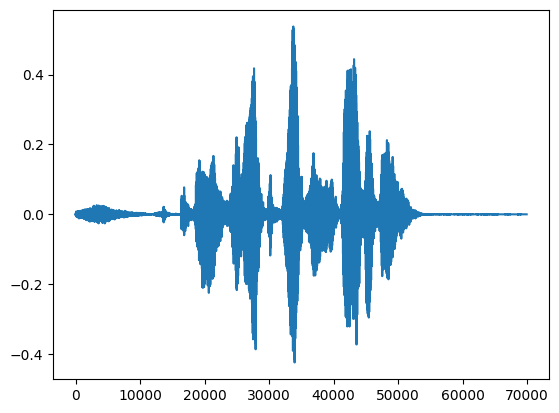

In [224]:
audio_path = '/home/alae/Desktop/journal_rev/rev_ravdess/test/ravdess/Actor_01//'
audio_names = os.listdir(audio_path)
y, sr = librosa.load(audio_path+audio_names[7], sr=16000)
plt.plot(y)

# Preporecessing

## Pre-emphasis

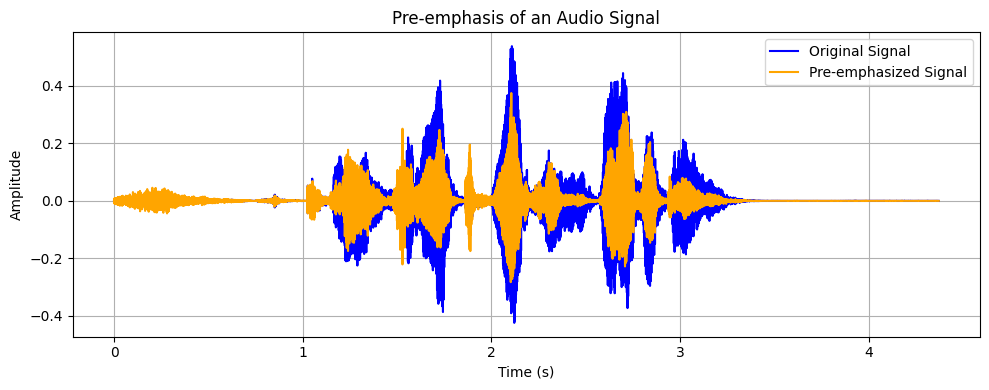

In [225]:
alpha = 0.97
y_2= np.append(y[0], y[1:] - alpha * y[:-1])
t = np.arange(len(y)) / sr

# Plot original vs. pre-emphasized signal (zoomed for clarity)
plt.figure(figsize=(10, 4))
plt.plot(t, y, label="Original Signal", color='blue')
plt.plot(t, y_2, label="Pre-emphasized Signal", color='orange')
plt.title("Pre-emphasis of an Audio Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Removing edge silence

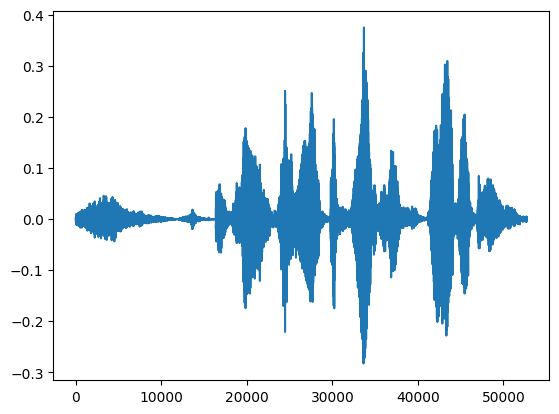

In [226]:
vad = librosa.effects.split(y_2, top_db=30)
y_2 = y_2[vad[0][0]:vad[-1][1]]
plt.plot(y_2)

## Hamming

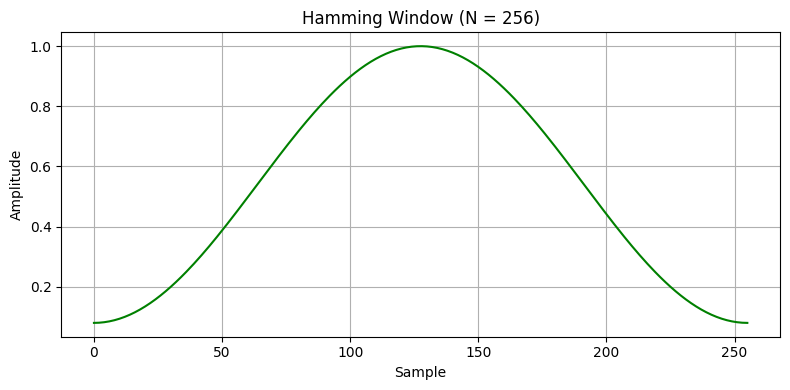

In [228]:
# Frame length (use the same as in your STFT/Mel spectrogram)
N = 256
n = np.arange(N)
hamming = 0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1))

# Plot Hamming window
plt.figure(figsize=(8, 4))
plt.plot(n, hamming, color='green')
plt.title("Hamming Window (N = 256)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract Mel Spectrogram

In [229]:
# === Parameters for Mel Spectrogram ===
n_fft = 512
win_length = 256
hop_length = 128
window = 'hamming'
n_mels = 64
fmax = 8000

# === Mel Spectrogram Function ===
def mel_spectrogram(y, sr, n_fft, win_length, hop_length, window, n_mels, fmax):
    # Compute power spectrogram
    spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window,
                                win_length=win_length, hop_length=hop_length)) ** 2
    # Apply Mel filter bank
    mel_spect = librosa.feature.melspectrogram(S=spect, sr=sr,
                                                n_mels=n_mels, fmax=fmax)
    # Convert to dB scale
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect

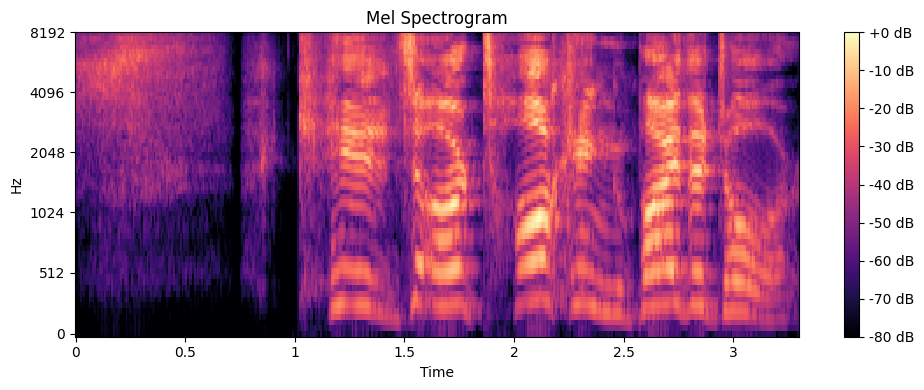

In [230]:
mel_spec = mel_spectrogram(y_2, sr, n_fft, win_length, hop_length, window, n_mels, fmax)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', fmax=fmax)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# Apply augmentations

In [234]:
# Define augmentation functions
def noisy_signal(signal, snr_low=15, snr_high=30):
    signal_len = len(signal)
    noise = np.random.normal(size=signal_len)
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2) / signal_len
    snr = np.random.randint(snr_low, snr_high)
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    return signal + K * noise

def pitch_shift(signal, sr, n_steps=0.25):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def time_stretch(signal, rate):
    return librosa.effects.time_stretch(signal, rate=0.9)

def speed_change(signal):
    return librosa.effects.time_stretch(signal, rate=1.2)

def time_shift(signal, shift_max=0.3):
    shift = int(len(signal) * shift_max)
    return np.roll(signal, shift)

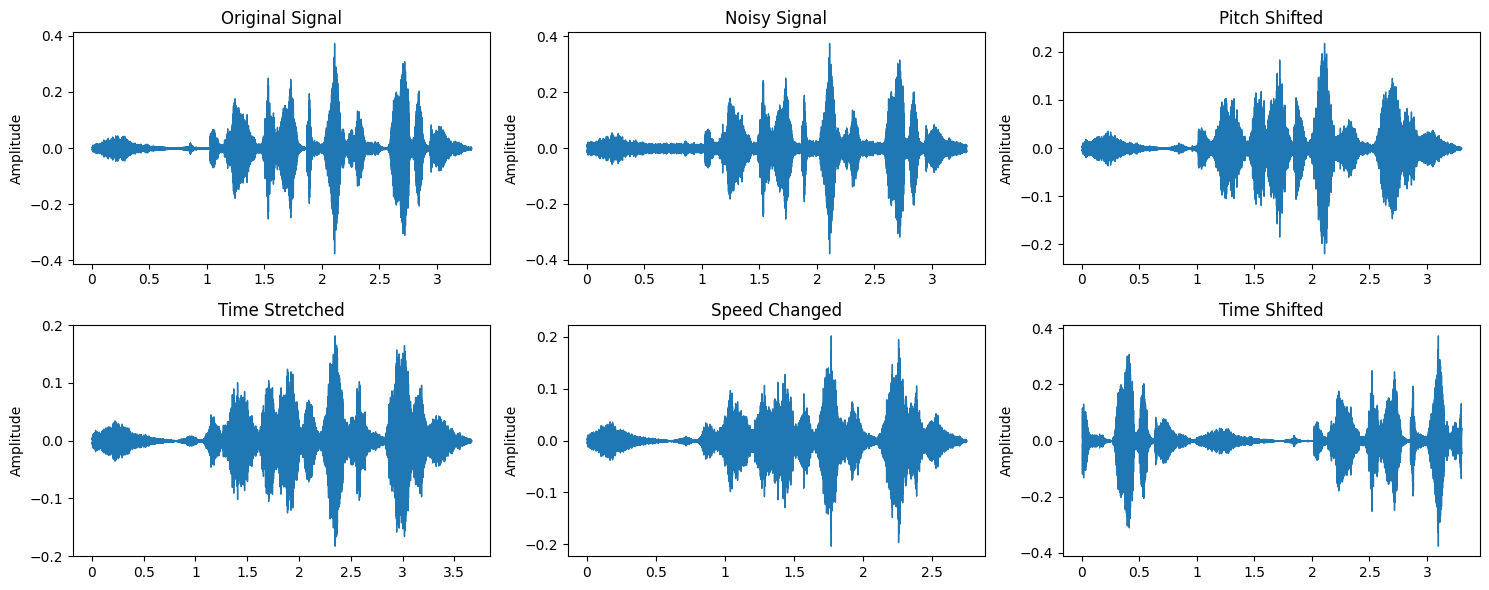

In [235]:
# Generate augmented signals
y_noisy = noisy_signal(y_2)
y_pitch = pitch_shift(y_2, sr)
y_stretch = time_stretch(y_2, 0.7)
y_speed = speed_change(y_2)
y_shift = time_shift(y_2)

# Create plot
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
signals = [y_2, y_noisy, y_pitch, y_stretch, y_speed, y_shift]
titles = ['Original Signal', 'Noisy Signal', 'Pitch Shifted', 'Time Stretched', 'Speed Changed', 'Time Shifted']

for i, ax in enumerate(axs.flat):
    librosa.display.waveshow(signals[i], sr=sr, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

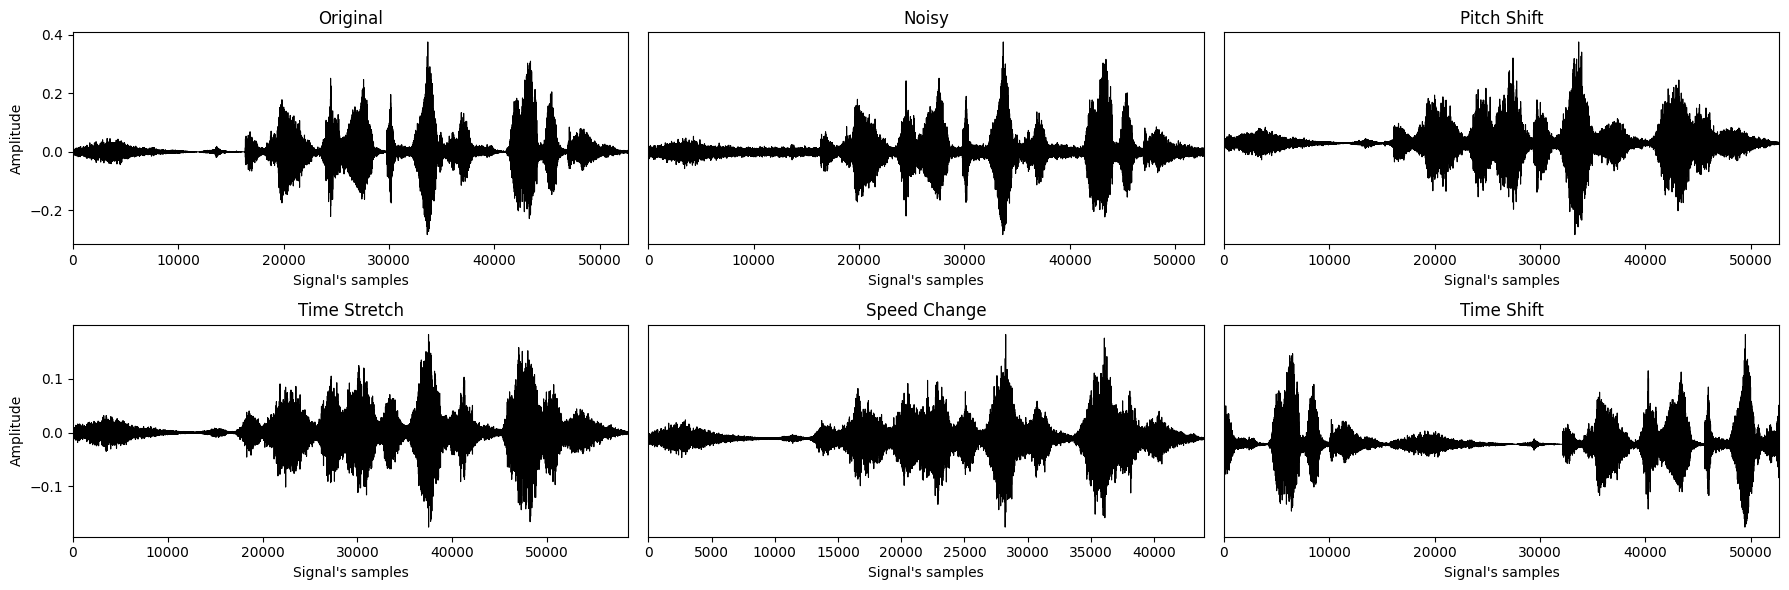

In [236]:
# Prepare for plotting
signals = [y_2, y_noisy, y_pitch, y_stretch, y_speed, y_shift]
titles = ['Original', 'Noisy', 'Pitch Shift', 'Time Stretch', 'Speed Change', 'Time Shift']

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

for i, (signal, title) in enumerate(zip(signals, titles)):
    ax = axes[i]
    ax.plot(signal, color='black', linewidth=0.8)
    ax.set_title(title, fontsize=12)
    ax.set_xlim([0, len(signal)])
    
    if i % 3 == 0:  # only first column plots
        ax.set_ylabel("Amplitude")
    else:
        ax.set_yticks([])
    #if i < 3 :  # only first column plots
    #ax.set_xticks([])
    ax.set_xlabel("Signal's samples")

plt.tight_layout()
plt.show()


## augmented spectrograms

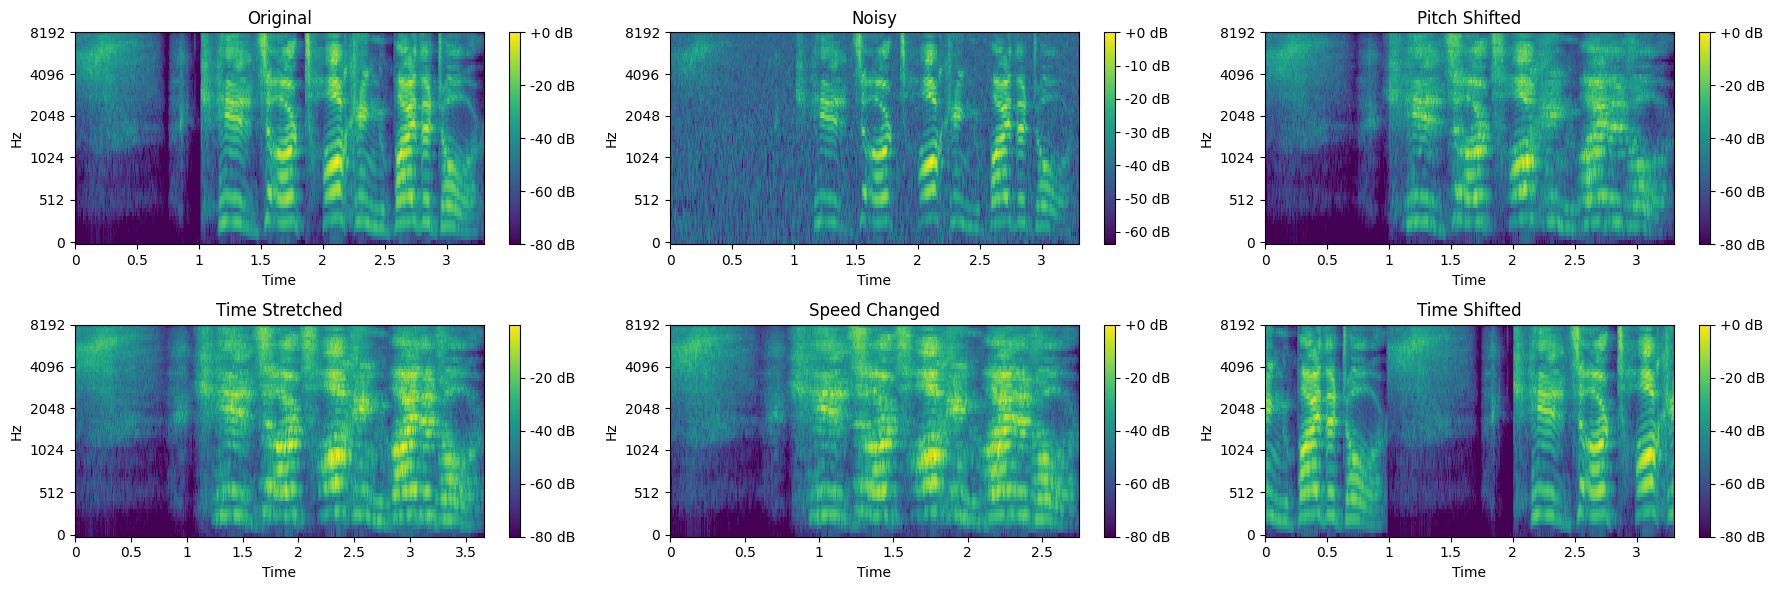

In [237]:
# List of signals and titles
signals = [y_2, y_noisy, y_pitch, y_stretch, y_speed, y_shift]
titles = ['Original', 'Noisy', 'Pitch Shifted', 'Time Stretched', 'Speed Changed', 'Time Shifted']

# Plot mel-spectrograms
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for i, ax in enumerate(axs.flat):
    mel_spec = mel_spectrogram(signals[i], sr, n_fft, win_length, hop_length, window, n_mels, fmax)
    img = librosa.display.specshow(mel_spec, sr=sr, hop_length=128, 
                               x_axis='time', y_axis='mel', fmax=8000, 
                               cmap='viridis', ax=ax)

    ax.set_title(titles[i])
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout()
plt.show()


# Framing of spectrogram

In [242]:
# framing function
def frame(x, max_frames=8, win_size=64):
    win_step = (x.shape[1] - win_size) // (max_frames - 1)
    win_step = max(win_step, 1)
    frames = np.zeros((max_frames, x.shape[0], win_size)).astype(np.float32)
    start = 0
    for t in range(max_frames):
        frames[t, :, :] = x[:, start:start + win_size].astype(np.float32)
        start += win_step
    return frames, win_step

In [244]:
spec = mel_spectrogram(y_2, sr, n_fft, win_length, hop_length, window, n_mels, fmax)
specs, step = frame(spec)
print('frames size:', specs.shape, 'Window step:', step)

frames size: (8, 64, 64) Window step: 49


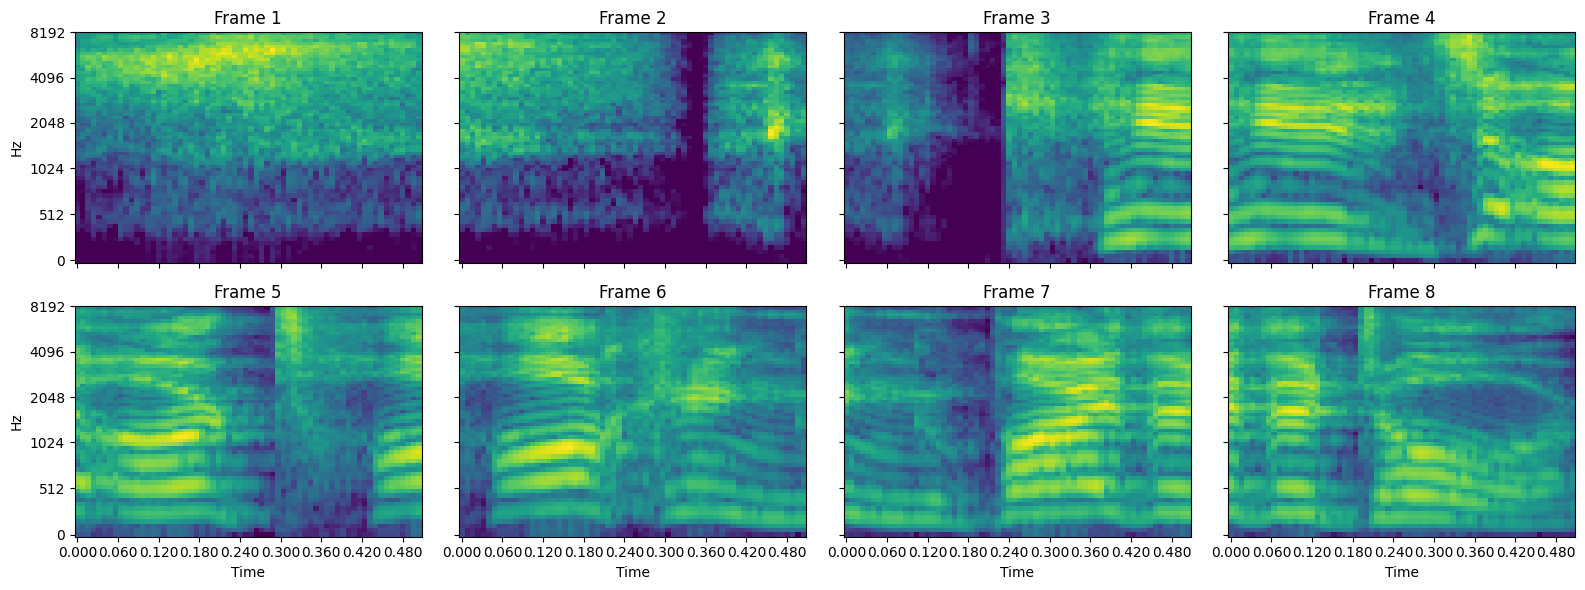

In [241]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    img = librosa.display.specshow(specs[i], sr=sr, hop_length=128, 
                               x_axis='time', y_axis='mel', fmax=8000, 
                               cmap='viridis', ax=ax)
    ax.set_title(f'Frame {i+1}')
    ax.label_outer()  
plt.tight_layout()
plt.show()